In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import torch as tc
genders = ['female', 'male']
male = ['male']
female = ['female']

In [3]:
their_semantics = [
    'Subject',
    'Measuring station',
    'repetition no.',
    'Bust girth',
    'Waist girth',
    'Hip girth',
    'Thigh girth R',
    'Upper arm girth R',
    'Neck girth',
    'Back neck point to waist',
    'Height (m)',
    'Sex'
]
our_semantic = [
    'subject',
    'measures_station',
    'repetition',
    'bust_chest_girth', # 5.3.4
    'waist_girth', # 5.3.10
    'hip_girth', # 5.3.13
    'thigh_girth', # 5.3.20
    'upper_arm_girth', # 5.3.16
    'neck_girth', # 5.3.2
    'neck_waist',
    'stature', # 5.1.1
    'gender'
]

station_list = ["MOVE4D", "Expert", "Our"]

measures = pd.read_pickle(f'data/move4d_cleaned_measures.zip')
measures = measures[their_semantics]
measures.columns = our_semantic
our_measures = pd.read_pickle("data/our_measures.zip")
measures = pd.concat([our_measures, measures]).drop(columns=["stature"])
measures = measures[measures['measures_station'].isin(["MOVE4D", "Expert measurer 1", "our"])]
measures.replace("Expert measurer 1", "Expert", inplace=True)
measures.replace("our", "Our", inplace=True)

In [4]:
measures.to_csv("our_move4d.csv")

<AxesSubplot:xlabel='variable', ylabel='value'>

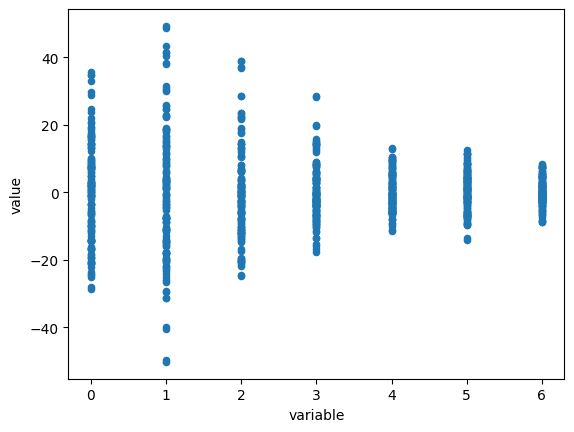

In [46]:
measures_semantic = ['bust_chest_girth', 'waist_girth', 'hip_girth', 'thigh_girth', 'upper_arm_girth', 'neck_girth', 'neck_waist', ]
a = measures[measures['measures_station']=="Our"][measures_semantic].reset_index(drop=True)
b = measures[measures['measures_station']=="MOVE4D"][measures_semantic].reset_index(drop=True)
size = a.shape[1]

c = pd.melt((a-b)/10)
c['variable'] = c.variable.factorize()[0]
c.plot(kind='scatter', x='variable', y='value')

<AxesSubplot:xlabel='variable', ylabel='value'>

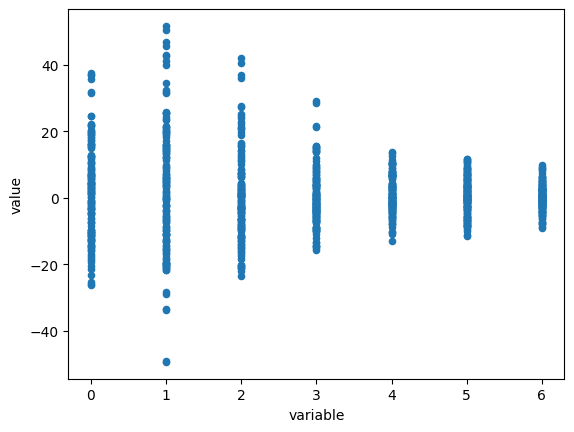

In [47]:
measures_semantic = ['bust_chest_girth', 'waist_girth', 'hip_girth', 'thigh_girth', 'upper_arm_girth', 'neck_girth', 'neck_waist', ]
a = measures[measures['measures_station']=="Our"][measures_semantic].reset_index(drop=True)
b = measures[measures['measures_station']=="Expert"][measures_semantic].reset_index(drop=True)
size = a.shape[1]

c = pd.melt((a-b)/10)
c['variable'] = c.variable.factorize()[0]
c.plot(kind='scatter', x='variable', y='value')

<AxesSubplot:xlabel='variable', ylabel='value'>

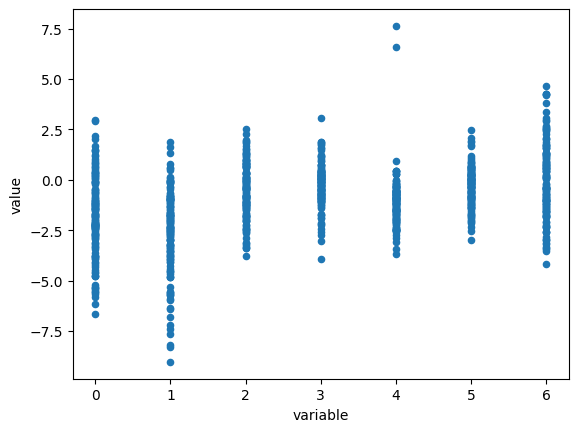

In [49]:
measures_semantic = ['bust_chest_girth', 'waist_girth', 'hip_girth', 'thigh_girth', 'upper_arm_girth', 'neck_girth', 'neck_waist', ]
a = measures[measures['measures_station']=="Expert"][measures_semantic].reset_index(drop=True)
b = measures[measures['measures_station']=="ZSA"][measures_semantic].reset_index(drop=True)
size = a.shape[1]

c = pd.melt((a-b)/10)
c['variable'] = c.variable.factorize()[0]
c.plot(kind='scatter', x='variable', y='value')

In [46]:
pd.read_pickle(f'data/move4d_cleaned_measures.zip')

,Subject,Measuring station,repetition no.,Neck girth,Back neck point to waist,Upper arm girth R,Back neck point to wrist R,Across back shoulder width,Bust girth,Waist girth,Hip girth,Thigh girth R,Total crotch length,Inside leg height,Phase,Sex,Age (years),Weight (kg),Height (m)
720,IEEEP2_01,3Davatarbody,1,334.764,403.619,299.967,756.064,375.219,896.625,789.734,1056.17,602.372,772.886,695.665,2,female,23,64.7,1.640
721,IEEEP2_01,3Davatarbody,2,330.442,397.442,299.504,753.638,368.942,886.254,794.827,1055.06,600.690,771.447,697.483,2,female,23,64.7,1.640
722,IEEEP2_01,eM+,1,322.500,436.300,288.100,765.600,424.300,865.800,715.000,1039.90,605.900,716.600,712.700,2,female,23,64.7,1.640
723,IEEEP2_01,eM+,2,327.100,439.300,285.100,757.500,426.900,862.700,705.900,1037.10,599.400,723.000,721.900,2,female,23,64.7,1.640
724,IEEEP2_01,MOVE4D,1,327.377,425.868,285.042,726.648,387.684,891.216,755.405,1057.48,629.809,771.791,714.434,2,female,23,64.7,1.640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,IEEEP2_72,3DLOOK,2,381.200,467.700,293.900,836.600,428.200,915.400,798.200,968.00,580.100,767.000,823.500,2,male,25,70.7,1.775
2007,IEEEP2_72,Expert measurer 1,1,355.000,435.000,305.000,850.000,435.000,930.000,825.000,985.00,565.000,785.000,835.000,2,male,25,70.7,1.775
2008,IEEEP2_72,Expert measurer 1,2,360.000,450.000,315.000,840.000,435.000,930.000,860.000,985.00,570.000,730.000,835.000,2,male,25,70.7,1.775
2009,IEEEP2_72,Expert measurer 5,1,355.000,427.000,321.000,795.000,434.000,936.000,854.000,969.00,579.000,755.000,845.000,2,male,25,70.7,1.775


In [74]:
a = measures[['neck_waist', 'measures_station', 'subject', 'gender']].reset_index(drop=True)
a = a[a['measures_station'].isin(["Our", "MOVE4D"])].reset_index(drop=True)
a1 = a[a['gender'] == 'female'].pivot_table(index="subject",columns="measures_station").to_numpy()
a2 = a[a['gender'] == 'male'].pivot_table(index="subject",columns="measures_station").to_numpy()
print(abs(a1[:,0] - a1[:,1]).mean(), abs(a1[:,0] - a1[:,1]).std(), abs(a2[:,0] - a2[:,1]).mean(), abs(a2[:,0] - a2[:,1]).std())


12.071824473063153 7.70591153714945 7.319838897705078 6.614607446929914


# CALC ICC

In [4]:
def calc_icc(a):
    # ONE WAY ANOVA
    numsub, numrep, numel = a.shape[0], a.shape[1], a.size
    mean_between = a.mean(axis=1)
    mean_within  = a.mean(axis=0)
    ssw = ((a - mean_within)**2).sum()
    ssb = ((a.T - mean_between)**2).sum()
    msw = ssw/(numsub-1)
    msb = ssb/(numel-numsub)
    # ICC
    # icc = msw/(msw+msb)
    icc = (msw-msb) / ( msw + (numrep-1) * msb)
    return icc

In [5]:
all_measures = []
for station in station_list:
    measures_of_station = []
    for measure in our_semantic[3:-1]:
        a = measures[measures['measures_station'] == station][['subject', 'repetition', measure]]
        a = pd.pivot_table(a, index='subject', columns='repetition').to_numpy()
        icc = calc_icc(a)
        measures_of_station.append(icc)
    all_measures.append(measures_of_station)
our_icc = pd.DataFrame(all_measures, station_list, our_semantic[3:-1]).sort_index()

In [6]:
our_icc.index = ['Expert', "MOVE4D", 'Our']
our_icc

,bust_chest_girth,waist_girth,hip_girth,thigh_girth,upper_arm_girth,neck_girth,neck_waist
Expert,0.985261,0.995322,0.993377,0.985685,0.905965,0.980058,0.911705
MOVE4D,0.994362,0.997641,0.999215,0.998118,0.995832,0.996013,0.972377
Our,0.996910,0.998163,0.998906,0.998217,0.994735,0.995889,0.973532


# CALC SEM

In [7]:
all_measures = []
for station in station_list:
    measures_of_station = []
    for measure in our_semantic[3:-1]:
        a = measures[measures['measures_station'] == station][['subject', 'repetition', measure]]
        b = pd.pivot_table(a, index='subject', columns='repetition').to_numpy()
        icc = calc_icc(b)
        sem = a[measure].std() * np.sqrt(1-icc)
        measures_of_station.append(sem)
    all_measures.append(measures_of_station)
our_sem = pd.DataFrame(all_measures, station_list, our_semantic[3:-1]).sort_index()

In [8]:
our_sem.index = ['Expert', "MOVE4D", 'Our']
our_sem.T.round(4)

,Expert,MOVE4D,Our
bust_chest_girth,12.2070,7.8704,5.6181
waist_girth,8.7663,6.4854,5.7769
hip_girth,7.9468,2.7363,3.0902
thigh_girth,6.9973,2.5784,2.6602
upper_arm_girth,12.2280,2.4856,2.5728
neck_girth,4.8231,2.3343,2.3806
neck_waist,9.2412,4.9256,3.7245


# CALC PSD

In [9]:
def calculate_psd(measure):
    data = measures
    f1 = data['repetition'] == 1
    f2 = data['repetition'] == 2
    data = data[ f1 | f2 ][['subject', 'measures_station', 'repetition', measure]]
    data = data.pivot_table(values=measure, index=['subject', 'repetition'], columns="measures_station")
    data = data.dropna()
    

    column_wise = []
    for column1 in data.columns:
        row_wise = []
        for column2 in data.columns:
            if column1 == column2:
                row_wise.append(np.nan)
            else:
                d1 = data[column1]
                d2 = data[column2]
                var = (d1-d2).var()
                sem1 = our_sem[measure].loc[column1]**2
                sem2 = our_sem[measure].loc[column2]**2
                value = np.sqrt(var + (sem1/2) + (sem2/2))
                row_wise.append(value)
        column_wise.append(row_wise)
    data = pd.DataFrame(column_wise, index=data.columns, columns=data.columns)
    data.index.name = None
    return data

In [10]:
neck_result = calculate_psd(measure='neck_girth')
MX = pd.Series({"MOVE/Expert": neck_result.loc["MOVE4D"]["Expert"]})
neck_result = neck_result.loc['Our'][:-1].append(MX)

In [11]:
bust_result = calculate_psd(measure='bust_chest_girth')
MX = pd.Series({"MOVE/Expert": bust_result.loc["MOVE4D"]["Expert"]})
bust_result = bust_result.loc['Our'][:-1].append(MX)

In [12]:
waist_result = calculate_psd(measure='waist_girth')
MX = pd.Series({"MOVE/Expert": waist_result.loc["MOVE4D"]["Expert"]})
waist_result = waist_result.loc['Our'][:-1].append(MX)

In [13]:
hip_result = calculate_psd(measure='hip_girth')
MX = pd.Series({"MOVE/Expert": hip_result.loc["MOVE4D"]["Expert"]})
hip_result = hip_result.loc['Our'][:-1].append(MX)

In [14]:
arm_result = calculate_psd(measure='upper_arm_girth')
MX = pd.Series({"MOVE/Expert": arm_result.loc["MOVE4D"]["Expert"]})
arm_result = arm_result.loc['Our'][:-1].append(MX)

In [15]:
thigh_result = calculate_psd(measure='thigh_girth')
MX = pd.Series({"MOVE/Expert": thigh_result.loc["MOVE4D"]["Expert"]})
thigh_result = thigh_result.loc['Our'][:-1].append(MX)

In [16]:
neck_waist_result = calculate_psd(measure='neck_waist')
MX = pd.Series({"MOVE/Expert": neck_waist_result.loc["MOVE4D"]["Expert"]})
neck_waist_result = neck_waist_result.loc['Our'][:-1].append(MX)

In [17]:
def calculate_mad():
    all_measures = []
    for station in station_list:
        measures_of_station = []
        a = measures[measures['measures_station'] == station]
        f1 = a['repetition'] == 1
        f2 = a['repetition'] == 2
        for measure in our_semantic[3:-1]:
            mean = np.nanmean(abs(a[f1][measure].to_numpy() - a[f2][measure].to_numpy()))
            measures_of_station.append(mean)
        all_measures.append(measures_of_station)
    return pd.DataFrame(all_measures, columns=our_semantic[3:-1], index=['MOVE4D','Expert','Our']).T

In [18]:
styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("font-size", "125%"),
                              ("color", 'black'),
                              ("font-weight", '700')])]

In [19]:
mad_table = calculate_mad()
mad_table = mad_table.style.set_caption("OUR vs MOVE4D MAD statistic result").set_table_styles(styles)
mad_table.format(precision=4)


,MOVE4D,Expert,Our
bust_chest_girth,8.5292,12.5347,6.8866
waist_girth,6.4874,9.1319,5.6992
hip_girth,3.0823,8.8194,3.5551
thigh_girth,2.6278,7.8472,2.9425
upper_arm_girth,2.7248,8.2014,2.6521
neck_girth,2.3442,5.2431,2.6996
neck_waist,5.1012,10.4514,4.2303


In [20]:
sem_table = our_sem.T.round(4)
sem_table = sem_table.style.set_caption("OUR vs MOVE4D SEM statistic result").set_table_styles(styles)
sem_table.format(precision=4)

,Expert,MOVE4D,Our
bust_chest_girth,12.2070,7.8704,5.6181
waist_girth,8.7663,6.4854,5.7769
hip_girth,7.9468,2.7363,3.0902
thigh_girth,6.9973,2.5784,2.6602
upper_arm_girth,12.2280,2.4856,2.5728
neck_girth,4.8231,2.3343,2.3806
neck_waist,9.2412,4.9256,3.7245


In [21]:
data_psd = pd.DataFrame(
    [neck_result, bust_result, waist_result, hip_result, arm_result,thigh_result, neck_waist_result],
    index=our_semantic[3:-1]).round(2)
data_psd.columns = ['Our vs Expert', "Our vs MOVE4D", 'MOVE vs Expert']
data_psd.to_csv("output/our_psd.csv")
data_psd = data_psd.style.set_caption("OUR vs MOVE4D PSD statistic result").set_table_styles(styles)
data_psd.format(precision=2)

,Our vs Expert,Our vs MOVE4D,MOVE vs Expert
bust_chest_girth,12.04,7.44,10.17
waist_girth,22.09,20.71,22.39
hip_girth,23.08,13.25,22.25
thigh_girth,15.04,11.94,14.79
upper_arm_girth,16.47,6.01,15.58
neck_girth,14.58,10.43,11.48
neck_waist,19.94,13.73,20.19
